# Importing Libraries and Loading Dataset

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, validation_curve, \
    learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

import time

# Load dataset
data = pd.read_csv('dataset/WineQT.csv')

# Dataset Preprocessing
Basic Information

In [56]:
print("Dataset Information:")
print(data.info())
print("\nDataset Sample:")
print(data.head())
print("\nMissing Values in Each Column:")
print(data.isnull().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB
None

Dataset Sample:
   fixed acidity  volatile acidi

# Data Visualization


Statistical Summary of Numerical Features:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000
mean,8.310378,0.529406,0.268663,2.531442,0.086836,15.654793,46.027704,0.996725,3.310748,0.658276,10.446072
std,1.746979,0.176443,0.196239,1.355849,0.047241,10.254819,32.808924,0.001923,0.156720,0.170573,1.082073
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.200000,0.550000,9.500000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997830,3.400000,0.730000,11.100000
max,15.900000,1.330000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000



Variance of Numerical Features:
total sulfur dioxide    1076.425508
free sulfur dioxide      105.161317
fixed acidity              3.051934
residual sugar             1.838326
alcohol                    1.170881
citric acid                0.038510
volatile acidity           0.031132
sulphates                  0.029095
pH                         0.024561
chlorides                  0.002232
density                    0.000004
dtype: float64


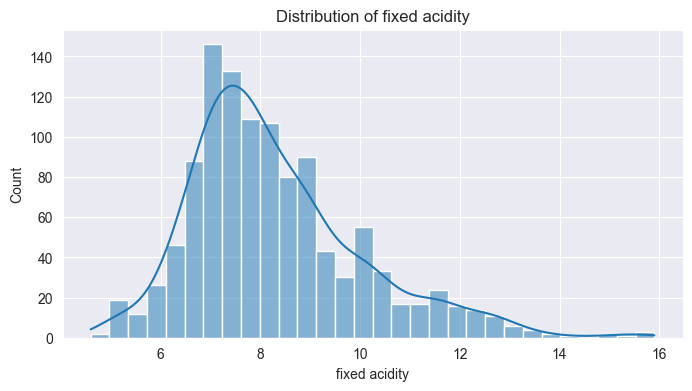

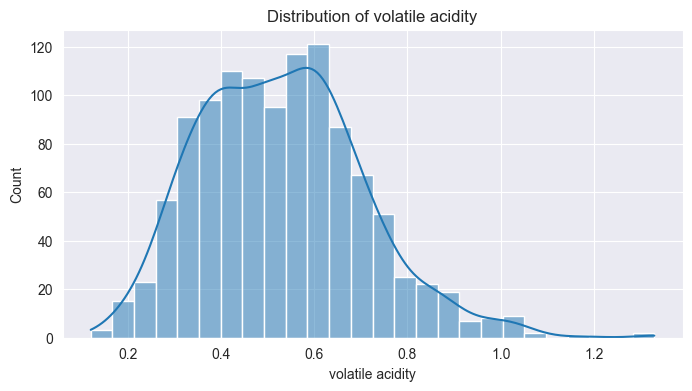

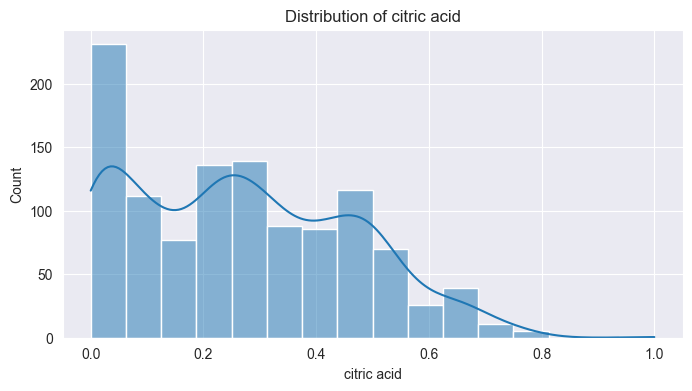

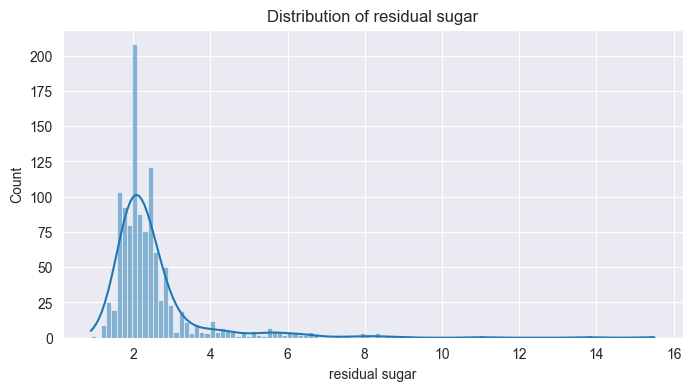

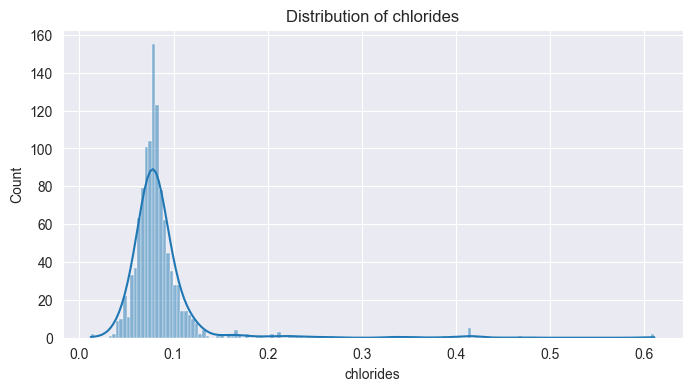

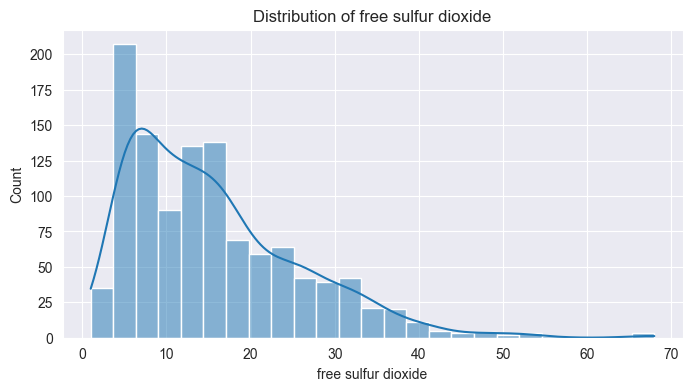

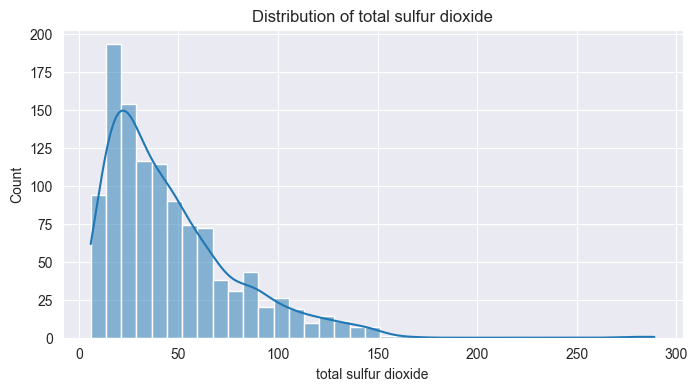

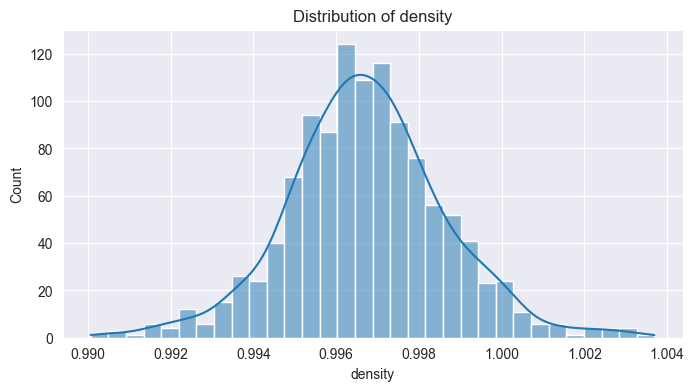

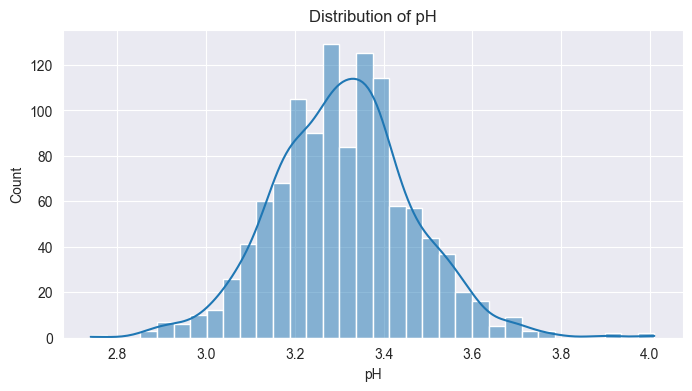

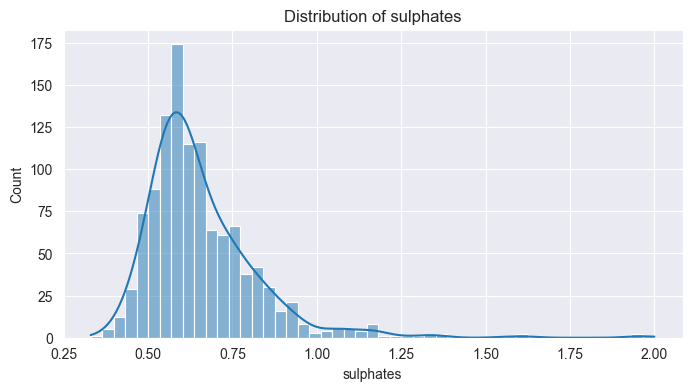

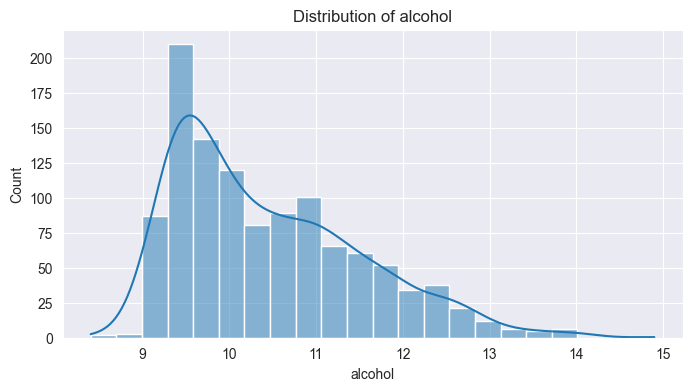

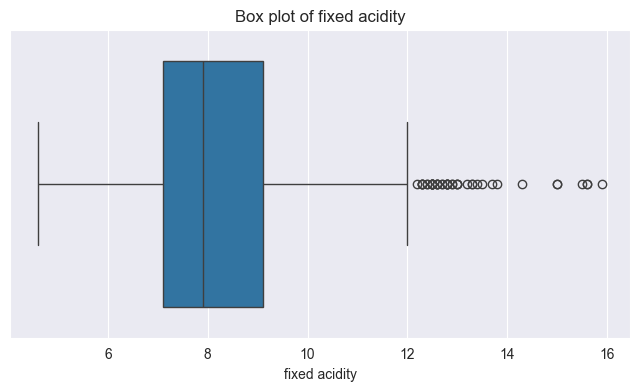

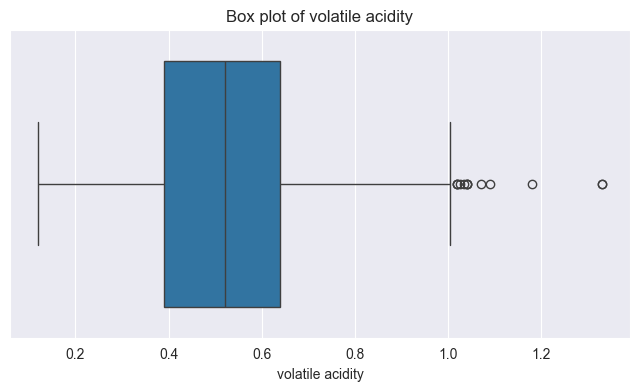

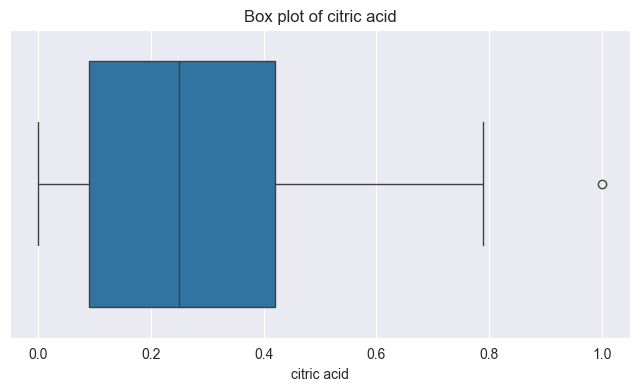

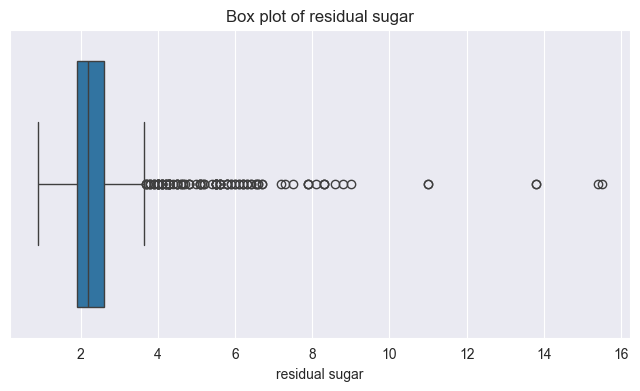

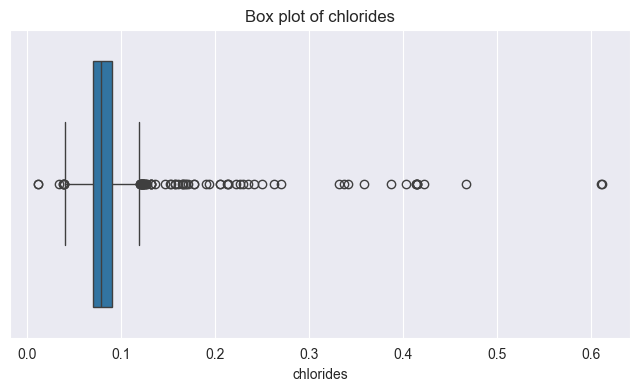

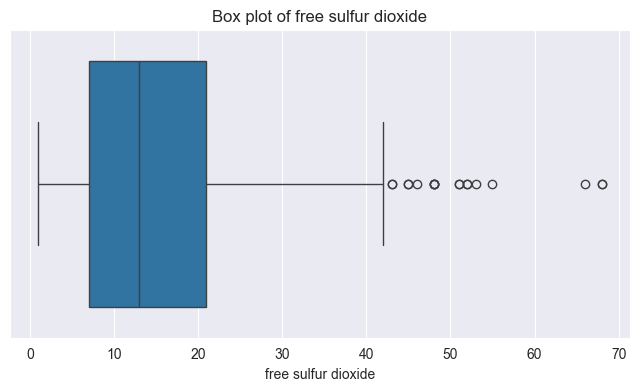

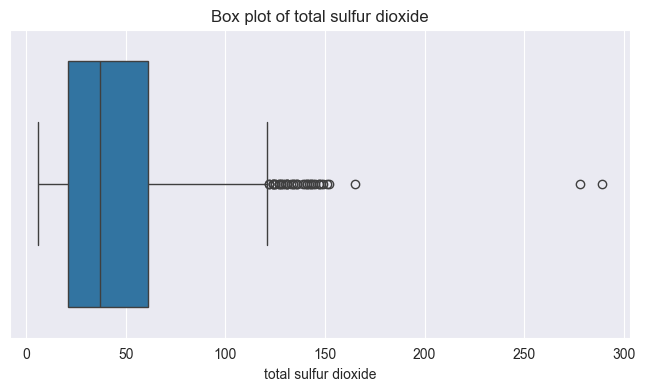

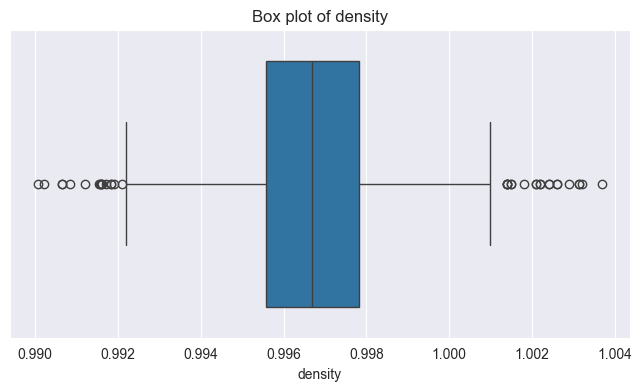

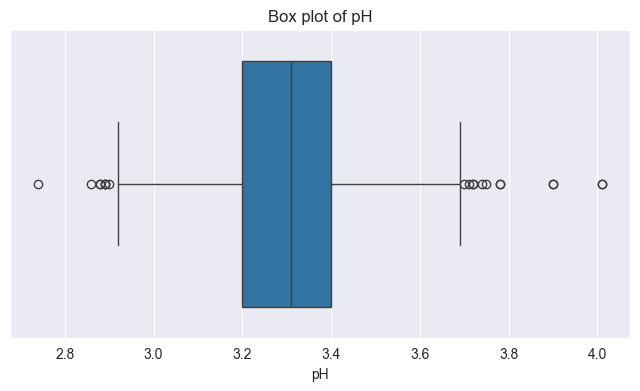

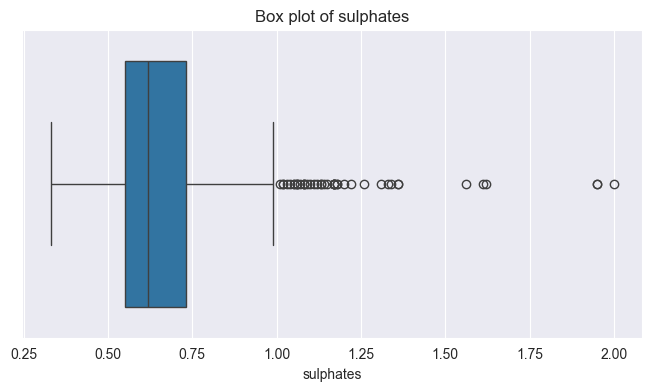

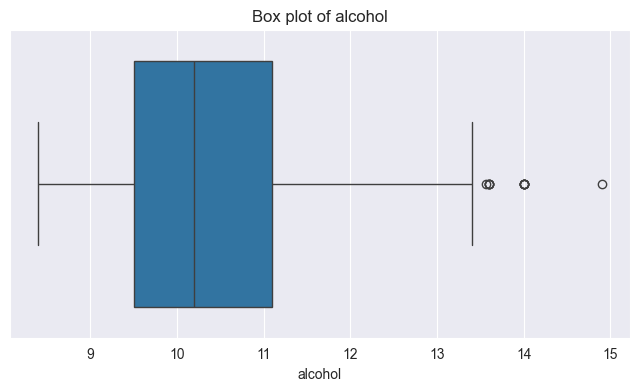

No categorical features to analyze.


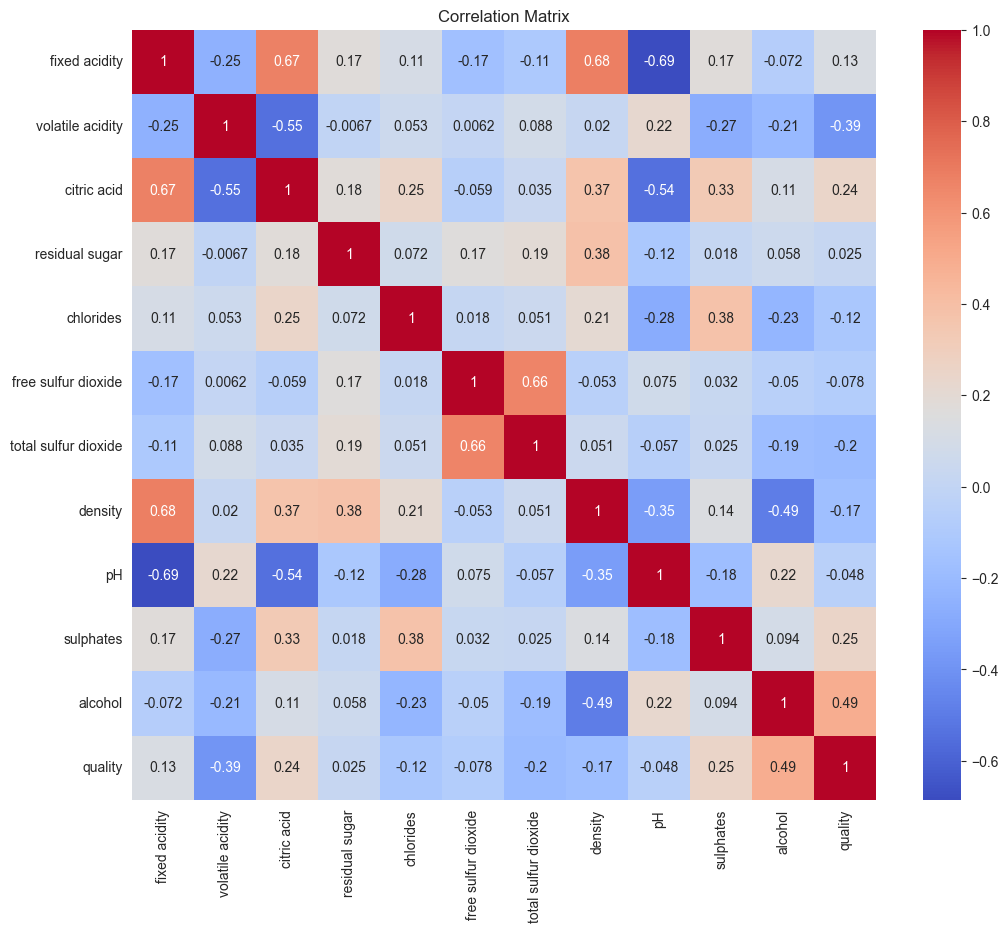

In [57]:
if 'Id' in data.columns:
    data = data.drop(columns=['Id'])
data = data[data['quality'] != 3]
# Identify numeric and categorical features
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

target_col = 'quality'

# Remove target column from features lists
if target_col in numeric_features:
    numeric_features.remove(target_col)
if target_col in categorical_features:
    categorical_features.remove(target_col)
    # Statistical summaries for numerical features
print("\nStatistical Summary of Numerical Features:")
display(data[numeric_features].describe())

# Variance of numerical features
variance = data[numeric_features].var().sort_values(ascending=False)
print("\nVariance of Numerical Features:")
print(variance)
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[feature].dropna())
    plt.title(f'Box plot of {feature}')
    plt.show()

if categorical_features:
    for feature in categorical_features:
        plt.figure(figsize=(10, 5))
        sns.countplot(y=data[feature], order=data[feature].value_counts().index)
        plt.title(f'Distribution of {feature}')
        plt.show()
else:
    print("No categorical features to analyze.")

# Correlation Matrix
plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Data Preprocessing and Transformation

In [58]:
X = data.drop(columns=[target_col])
y = data[target_col]
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


# Function to Train and Evaluate Models

In [59]:
def train_and_evaluate(model, param_grid, X_train, y_train, model_name):
    clf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    random_search = RandomizedSearchCV(clf_pipeline, param_distributions=param_grid, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    print(f"\n{model_name} Best Parameters: {random_search.best_params_}")
    print(f"{model_name} Cross-validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")
    
    return best_model, random_search.cv_results_, cv_scores

# Decision Tree Training

In [60]:
dt_model = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}
best_dt_model, dt_results, cv_scores_dt = train_and_evaluate(dt_model, param_grid_dt, X_train, y_train, "Decision Tree")



Decision Tree Best Parameters: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 3, 'classifier__criterion': 'entropy'}
Decision Tree Cross-validation Accuracy: 0.55 ± 0.04


# Logistic Regression Training

In [61]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga']
}

best_lr_model, lr_results, cv_scores_lr = train_and_evaluate(lr_model, param_grid_lr, X_train, y_train, "Logistic Regression")


/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Logistic Regression Best Parameters: {'classifier__solver': 'lbfgs', 'classifier__penalty': 'l2', 'classifier__C': 1}
Logistic Regression Cross-validation Accuracy: 0.60 ± 0.02


# K-Nearest Neighbors Training

In [62]:
knn_model = KNeighborsClassifier()

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

best_knn_model, knn_results, cv_scores_knn = train_and_evaluate(knn_model, param_grid_knn, X_train, y_train, "KNN")


/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



KNN Best Parameters: {'classifier__weights': 'distance', 'classifier__n_neighbors': 7, 'classifier__metric': 'manhattan'}
KNN Cross-validation Accuracy: 0.62 ± 0.02


# Evaluation on Validation Set


Decision Tree Validation Accuracy: 0.51
Decision Tree Validation Precision: 0.71
Decision Tree Validation Recall: 0.30
Decision Tree Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         9
           5       0.65      0.47      0.54        94
           6       0.45      0.65      0.53        91
           7       0.46      0.41      0.43        32
           8       0.00      0.00      0.00         2

    accuracy                           0.51       228
   macro avg       0.31      0.30      0.30       228
weighted avg       0.51      0.51      0.50       228

Decision Tree Confusion Matrix:
[[ 0  3  6  0  0]
 [ 0 44 47  3  0]
 [ 0 21 59 11  0]
 [ 0  0 19 13  0]
 [ 0  0  1  1  0]]


/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

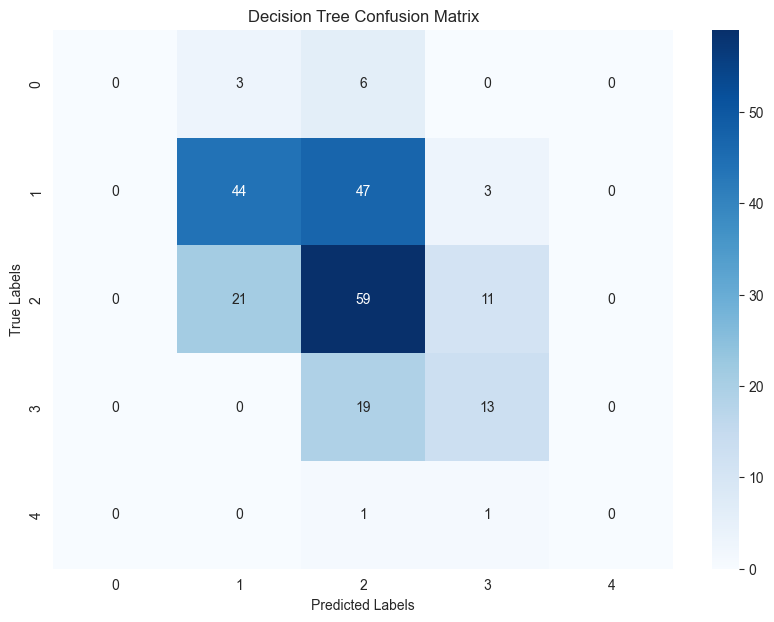


Logistic Regression Validation Accuracy: 0.57
Logistic Regression Validation Precision: 0.72
Logistic Regression Validation Recall: 0.31
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         9
           5       0.65      0.74      0.70        94
           6       0.50      0.57      0.54        91
           7       0.44      0.25      0.32        32
           8       0.00      0.00      0.00         2

    accuracy                           0.57       228
   macro avg       0.32      0.31      0.31       228
weighted avg       0.53      0.57      0.55       228

Logistic Regression Confusion Matrix:
[[ 0  4  4  1  0]
 [ 0 70 23  1  0]
 [ 0 31 52  8  0]
 [ 0  2 22  8  0]
 [ 0  0  2  0  0]]


/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

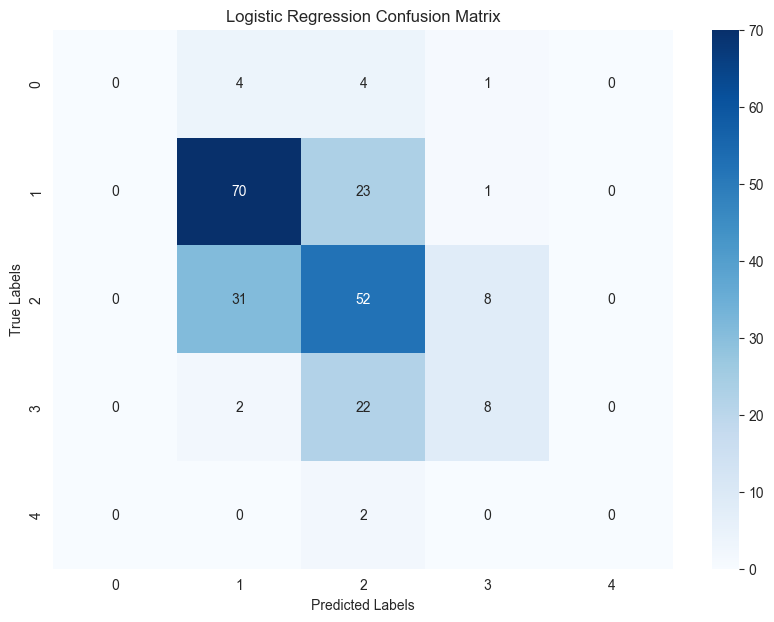

/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/volodic/PycharmProjects/ML-project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf


KNN Validation Accuracy: 0.58
KNN Validation Precision: 0.54
KNN Validation Recall: 0.34
KNN Classification Report:
              precision    recall  f1-score   support

           4       0.00      0.00      0.00         9
           5       0.63      0.65      0.64        94
           6       0.56      0.63      0.59        91
           7       0.50      0.44      0.47        32
           8       0.00      0.00      0.00         2

    accuracy                           0.58       228
   macro avg       0.34      0.34      0.34       228
weighted avg       0.55      0.58      0.57       228

KNN Confusion Matrix:
[[ 0  6  2  1  0]
 [ 0 61 31  2  0]
 [ 0 24 57  9  1]
 [ 0  6 11 14  1]
 [ 0  0  0  2  0]]


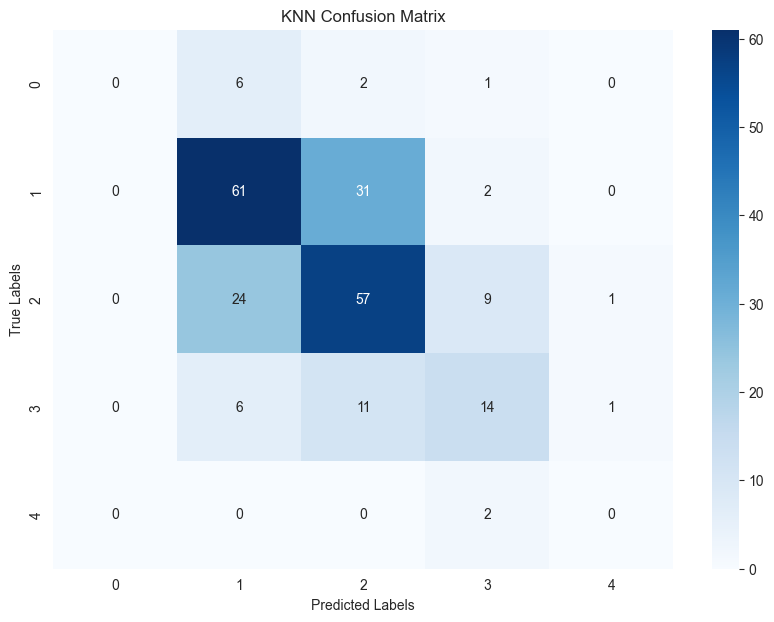

In [63]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Fit the model on training data
    model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_val, y_pred, average='macro', zero_division=1)
    report = classification_report(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    print(f"\n{model_name} Validation Accuracy: {accuracy:.2f}")
    print(f"{model_name} Validation Precision: {precision:.2f}")
    print(f"{model_name} Validation Recall: {recall:.2f}")
    print(f"{model_name} Classification Report:\n{report}")
    print(f"{model_name} Confusion Matrix:\n{conf_matrix}")
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    return accuracy, precision, recall

# Evaluate Decision Tree on val set 
dt_val_accuracy, dt_val_precision, dt_val_recall = evaluate_model(best_dt_model, X_train, y_train, X_val, y_val, "Decision Tree")

# Evaluate Logistic Regression on val set 
lr_val_accuracy, lr_val_precision, lr_val_recall = evaluate_model(best_lr_model, X_train, y_train, X_val, y_val, "Logistic Regression")

# Evaluate KNN on val set
knn_val_accuracy, knn_val_precision, knn_val_recall = evaluate_model(best_knn_model, X_train, y_train, X_val, y_val, "KNN")


# Feature Importance Analysis

Feature Names After Preprocessing:
['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol']


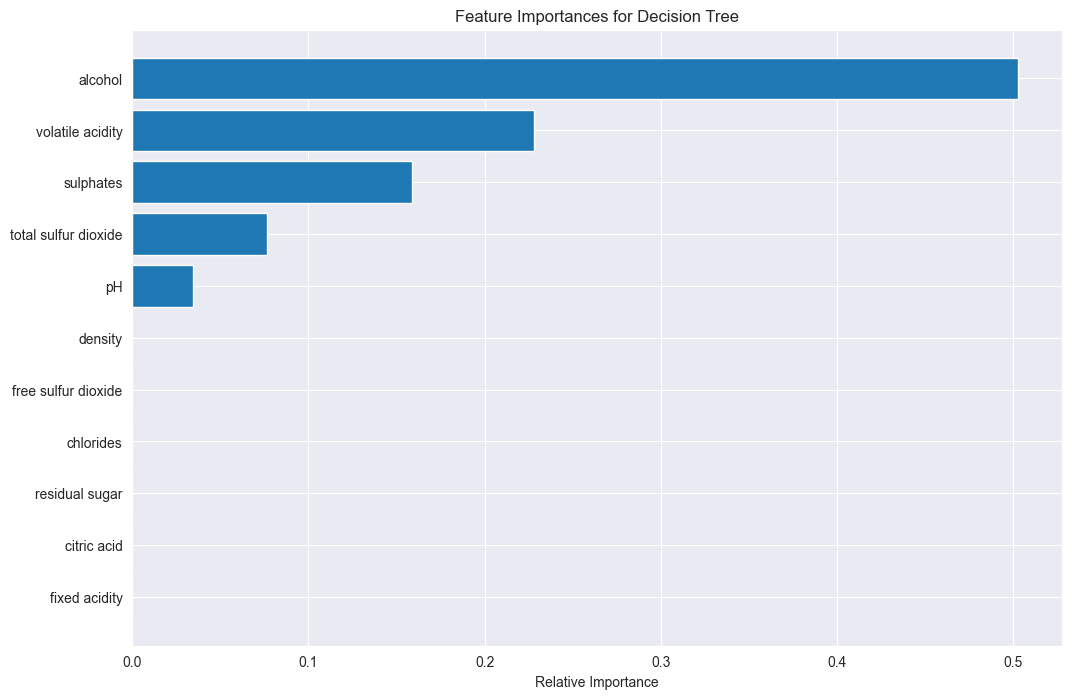

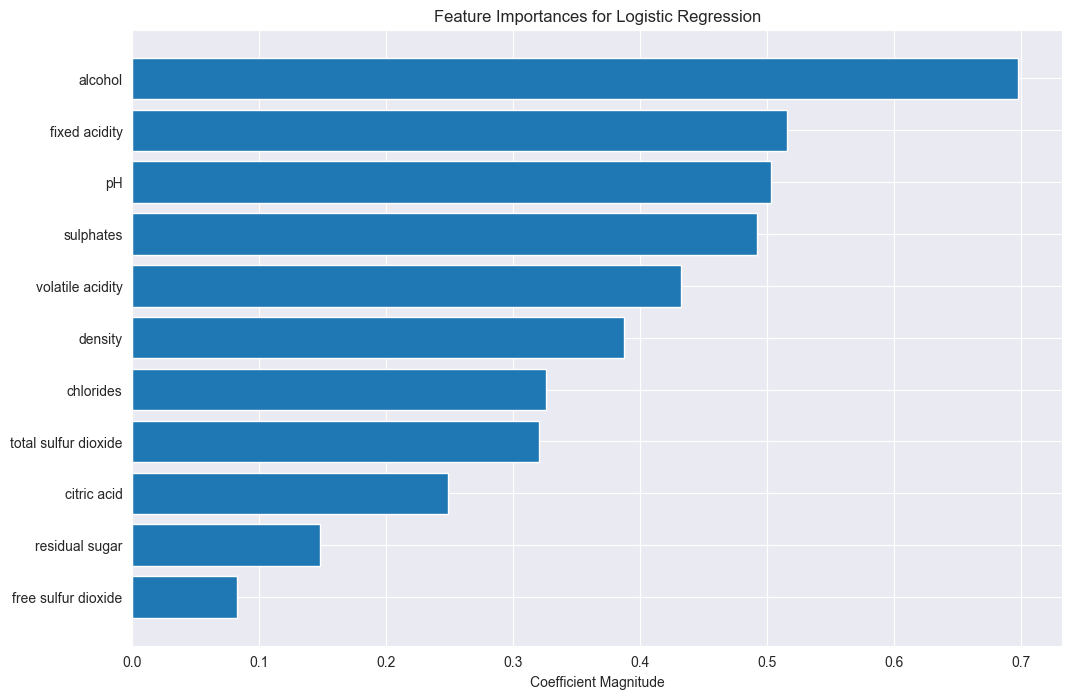

Elapsed time to compute permutation importances: 0.184 seconds


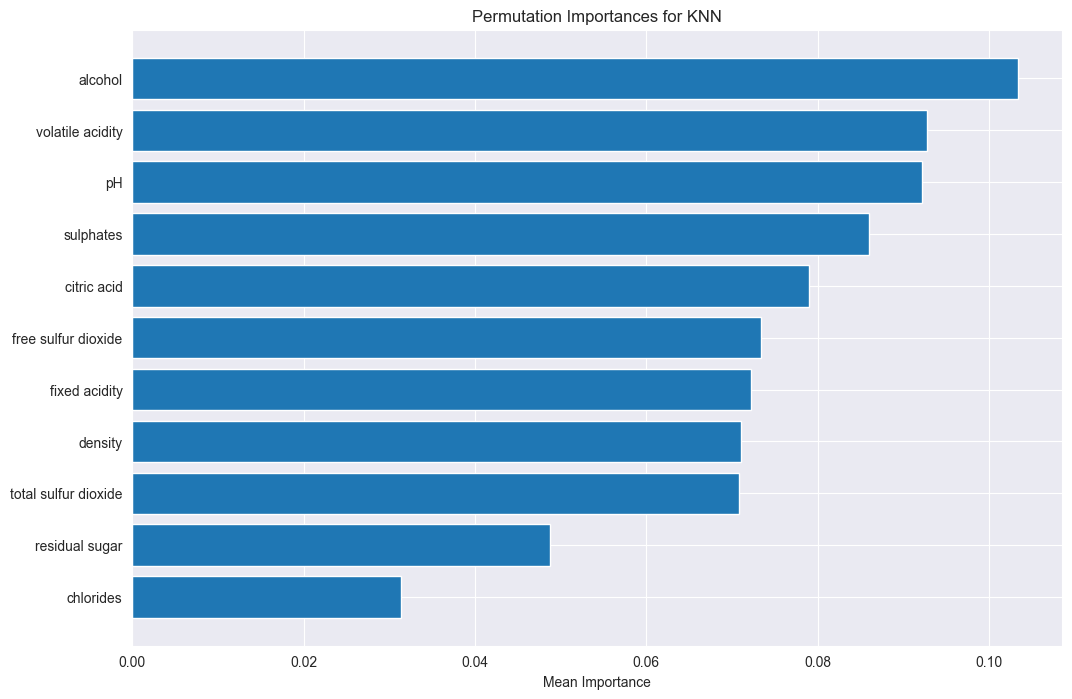

In [64]:
# Explicitly fit the preprocessor on the training data
preprocessor.fit(X_train)

# Get feature names
def get_feature_names(fitted_preprocessor, numeric_features, categorical_features):
    # Numeric features remain unchanged
    num_features = numeric_features
    # Access the fitted OneHotEncoder within the preprocessor
    if 'cat' in fitted_preprocessor.transformers:
        cat_encoder = fitted_preprocessor.named_transformers_['cat'].named_steps['onehot']
        # Get feature names from OneHotEncoder
        cat_features = cat_encoder.get_feature_names_out(categorical_features)
    else:
        cat_features = []
    # Combine feature names
    return np.concatenate([num_features, cat_features])

# Use the fitted preprocessor to get feature names
feature_names = get_feature_names(preprocessor, numeric_features, categorical_features)

# Display the feature names
print("Feature Names After Preprocessing:")
print(feature_names)

# Decision Tree Feature Importance
importances_dt = best_dt_model.named_steps['classifier'].feature_importances_
indices_dt = np.argsort(importances_dt)[::-1]

# Plot the top N feature importances
n_top_features = min(20, len(feature_names))
plt.figure(figsize=(12, 8))
plt.title("Feature Importances for Decision Tree")
plt.barh(range(n_top_features), importances_dt[indices_dt][:n_top_features], align='center')
plt.yticks(range(n_top_features), [feature_names[i] for i in indices_dt[:n_top_features]])
plt.gca().invert_yaxis()  # Most important at the top
plt.xlabel("Relative Importance")
plt.show()

# Logistic Regression Feature Importance
coefficients = np.abs(best_lr_model.named_steps['classifier'].coef_)
if coefficients.ndim > 1:
    feature_importance_lr = np.mean(coefficients, axis=0)
else:
    feature_importance_lr = coefficients
indices_lr = np.argsort(feature_importance_lr)[::-1]

# Plot the top N feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances for Logistic Regression")
plt.barh(range(n_top_features), feature_importance_lr[indices_lr][:n_top_features], align='center')
plt.yticks(range(n_top_features), [feature_names[i] for i in indices_lr[:n_top_features]])
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Magnitude")
plt.show()

# KNN Feature Importance using permutation importance
subset_size = min(1000, X_train.shape[0])
X_subset = X_train.sample(n=subset_size, random_state=42)
y_subset = y_train.loc[X_subset.index]

start_time = time.time()
result = permutation_importance(best_knn_model, X_subset, y_subset, n_repeats=5, random_state=42, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute permutation importances: {elapsed_time:.3f} seconds")

importances_knn = result.importances_mean
indices_knn = np.argsort(importances_knn)[::-1]

# Plot the top N feature importances
plt.figure(figsize=(12, 8))
plt.title("Permutation Importances for KNN")
plt.barh(range(n_top_features), importances_knn[indices_knn][:n_top_features], align='center')
plt.yticks(range(n_top_features), [feature_names[i] for i in indices_knn[:n_top_features]])
plt.gca().invert_yaxis()
plt.xlabel("Mean Importance")
plt.show()


# Comparison Between Classifiers

,Classifier,Validation Accuracy,Cross-Validation Accuracy,Validation Precision,Validation Recall
0,Decision Tree,0.508772,0.553564,0.711663,0.304537
1,Logistic Regression,0.570175,0.597606,0.720701,0.313222
2,KNN,0.578947,0.618173,0.538644,0.342562


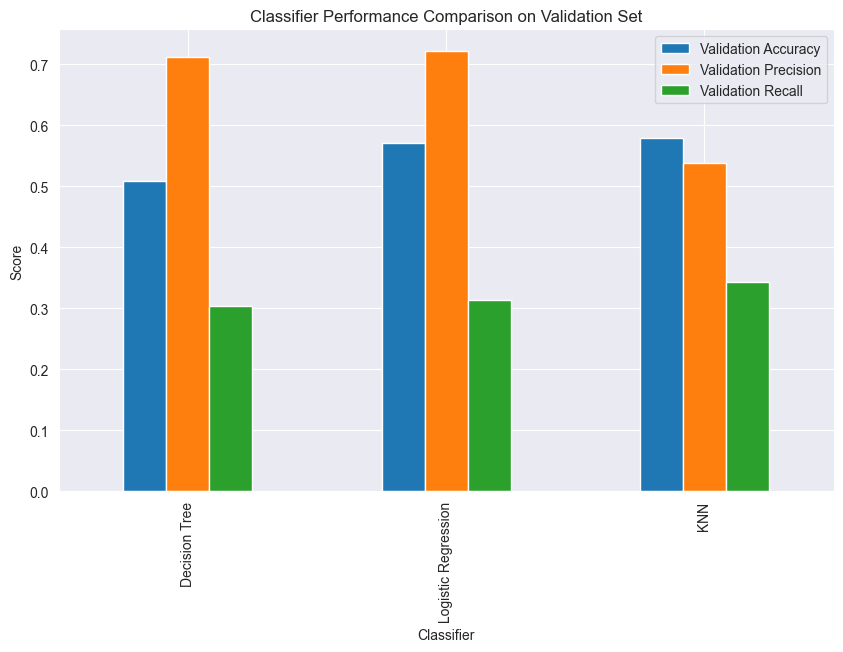

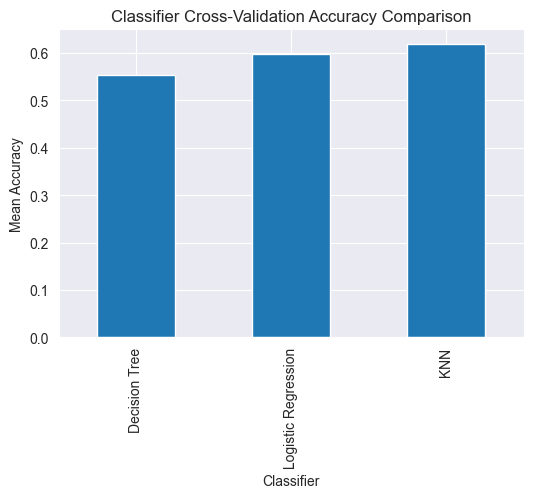

In [65]:
performance_summary = pd.DataFrame({
    'Classifier': ['Decision Tree', 'Logistic Regression', 'KNN'],
    'Validation Accuracy': [dt_val_accuracy, lr_val_accuracy, knn_val_accuracy],
    'Cross-Validation Accuracy': [cv_scores_dt.mean(), cv_scores_lr.mean(), cv_scores_knn.mean()],
    'Validation Precision': [dt_val_precision, lr_val_precision, knn_val_precision],
    'Validation Recall': [dt_val_recall, lr_val_recall, knn_val_recall]
})

display(performance_summary)

metrics = ['Validation Accuracy', 'Validation Precision', 'Validation Recall']
performance_summary.set_index('Classifier')[metrics].plot(kind='bar', figsize=(10, 6))
plt.title('Classifier Performance Comparison on Validation Set')
plt.ylabel('Score')
plt.show()

performance_summary.set_index('Classifier')['Cross-Validation Accuracy'].plot(kind='bar', figsize=(6, 4))
plt.title('Classifier Cross-Validation Accuracy Comparison')
plt.ylabel('Mean Accuracy')
plt.show()

In [66]:
# Hyperparameter Effects

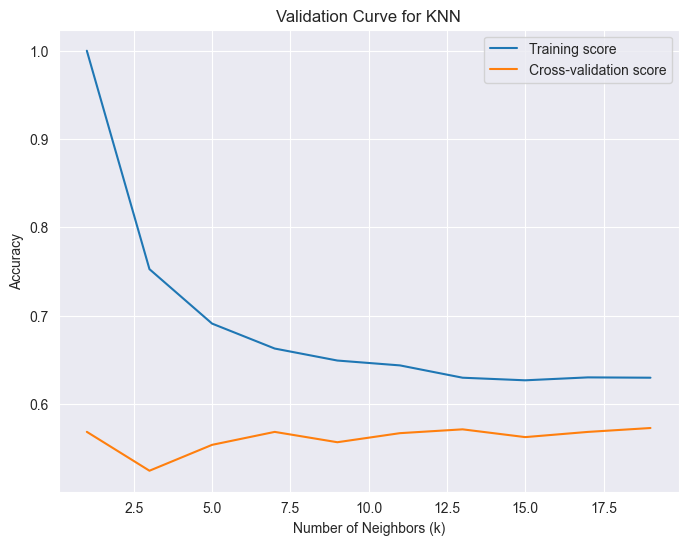

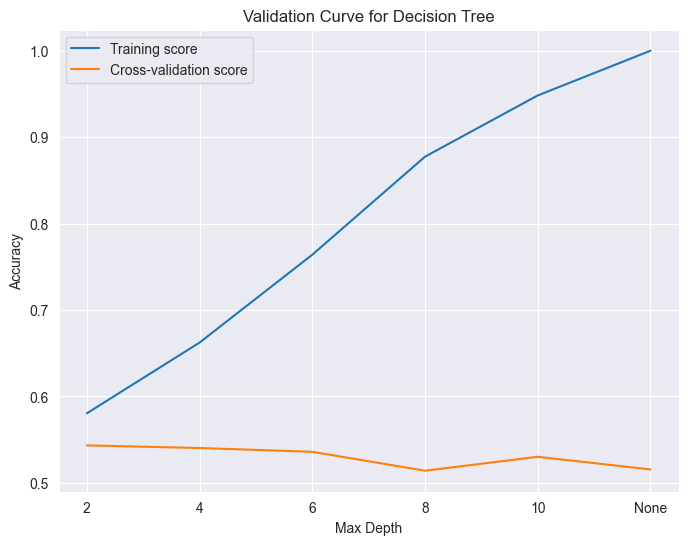

In [67]:
# Validation Curve for KNN (varying n_neighbors)
param_range = range(1, 20, 2)
train_scores_knn, test_scores_knn = validation_curve(
    Pipeline([('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]), 
    X_train, y_train, param_name='classifier__n_neighbors',
    param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1
)

train_scores_mean_knn = np.mean(train_scores_knn, axis=1)
test_scores_mean_knn = np.mean(test_scores_knn, axis=1)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_scores_mean_knn, label='Training score')
plt.plot(param_range, test_scores_mean_knn, label='Cross-validation score')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for KNN')
plt.legend()
plt.show()

# Validation Curve for Decision Tree (varying max_depth)
param_range = [2, 4, 6, 8, 10, None]
train_scores_dt, test_scores_dt = validation_curve(
    Pipeline([('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=42))]), 
    X_train, y_train, param_name='classifier__max_depth',
    param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1
)

train_scores_mean_dt = np.mean(train_scores_dt, axis=1)
test_scores_mean_dt = np.mean(test_scores_dt, axis=1)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot([str(d) for d in param_range], train_scores_mean_dt, label='Training score')
plt.plot([str(d) for d in param_range], test_scores_mean_dt, label='Cross-validation score')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Decision Tree')
plt.legend()
plt.show()


Learning Curves for Model Performance Analysis

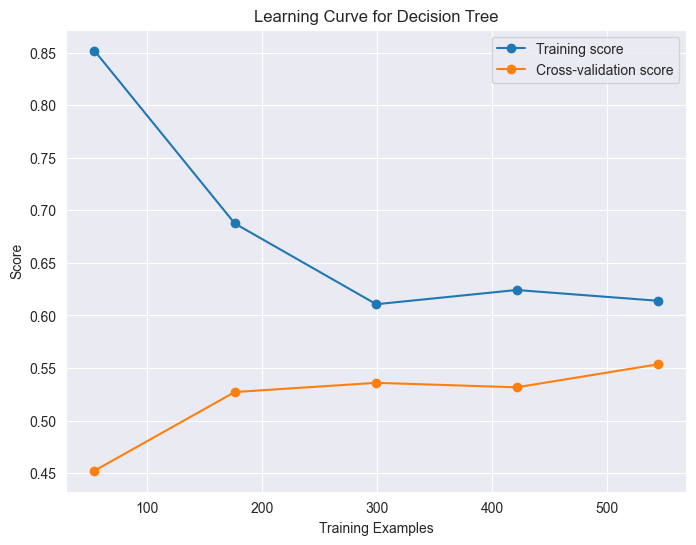

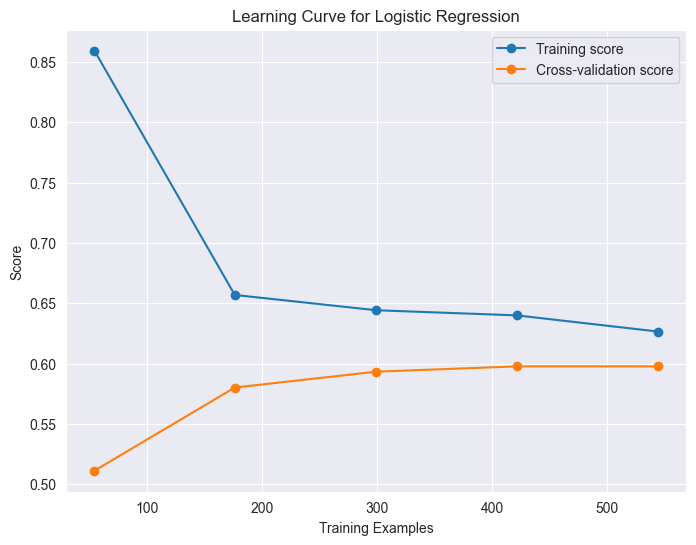

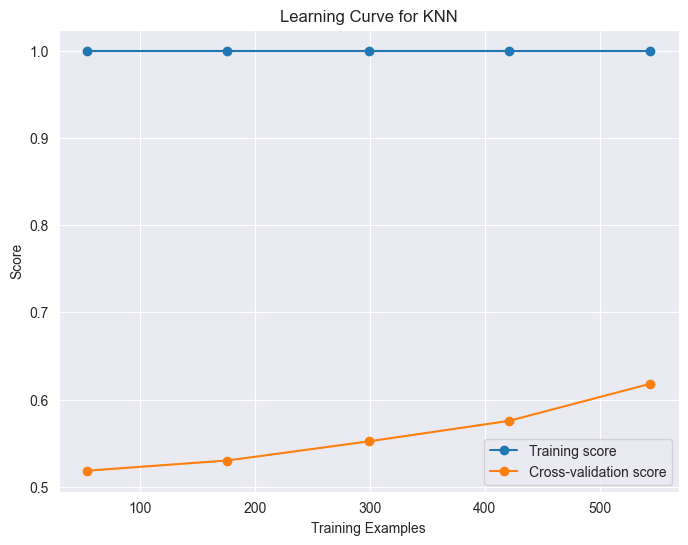

In [68]:
train_sizes = np.linspace(0.1, 1.0, 5)

# Decision Tree Learning Curve
train_sizes_dt, train_scores_dt, test_scores_dt = learning_curve(
    best_dt_model, X_train, y_train, cv=5, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)

train_scores_mean_dt = np.mean(train_scores_dt, axis=1)
test_scores_mean_dt = np.mean(test_scores_dt, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_dt, train_scores_mean_dt, 'o-', label="Training score")
plt.plot(train_sizes_dt, test_scores_mean_dt, 'o-', label="Cross-validation score")
plt.title('Learning Curve for Decision Tree')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend()
plt.show()

# Logistic Regression Learning Curve
train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(
    best_lr_model, X_train, y_train, cv=5, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)

train_scores_mean_lr = np.mean(train_scores_lr, axis=1)
test_scores_mean_lr = np.mean(test_scores_lr, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_lr, train_scores_mean_lr, 'o-', label="Training score")
plt.plot(train_sizes_lr, test_scores_mean_lr, 'o-', label="Cross-validation score")
plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend()
plt.show()

# KNN Learning Curve
train_sizes_knn, train_scores_knn, test_scores_knn = learning_curve(
    best_knn_model, X_train, y_train, cv=5, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)

train_scores_mean_knn = np.mean(train_scores_knn, axis=1)
test_scores_mean_knn = np.mean(test_scores_knn, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes_knn, train_scores_mean_knn, 'o-', label="Training score")
plt.plot(train_sizes_knn, test_scores_mean_knn, 'o-', label="Cross-validation score")
plt.title('Learning Curve for KNN')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend()
plt.show()